In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,Id,User Name,Personal URL,Profile Cover Image Status,Profile Verification Status,Profile Text Color,Profile Page Color,Profile Theme Color,Is Profile View Size Customized?,UTC Offset,Location,Location Public Visibility,User Language,Profile Creation Timestamp,User Time Zone,Num of Followers,Num of People Following,Num of Status Updates,Num of Direct Messages,Profile Category,Avg Daily Profile Visit Duration in seconds,Avg Daily Profile Clicks,Profile Image,Num of Profile Likes
0,AL85S14OMDPF01I9,Mf9vfld4Vfe,NaN,Set,Verified,db1a2c,eaf0f2,e70409,False,39600.0,NaN,Enabled,en,Thu Nov 27 05:24:59 +0000 2008,Sydney,95763,4289,30809,873,business,14.792,1.5761,AL85S14OMDPF01I9.png,2815
1,HI11QOPD7BLJTO7Q,xl9gaGN0hxM_,NaN,Set,Verified,0099cc,f6ffd1,fff04d,False,NaN,mumbai,Enabled,en,Fri Jan 15 18:00:46 +0000 2010,NaN,1018746,289,8150,290,unknown,8.183,11.2782,HI11QOPD7BLJTO7Q.png,1242
2,JS49LP5P72RI1OQB,d_uiMm,NaN,Set,Not verified,1fc2de,efefef,1fc2de,False,-18000.0,NYC + 70 Countries Worldwide,Enabled,en,Fri Oct 02 20:15:06 +0000 2009,Central Time (US & Canada),13444,1876,4698,227,unknown,31.823,0.5725,JS49LP5P72RI1OQB.png,1559
3,S0GDSC09MACCLBJP,hfylaRr,https://blob/e/g9pex_vS.com,Not set,Verified,050000,616161,00090a,False,-14400.0,"Indianapolis, In",Enabled,en,Thu Feb 19 14:37:22 +0000 2009,Eastern Time (US & Canada),339168,1148,53216,4035,business,23.052,4.0265,S0GDSC09MACCLBJP.png,6342
4,CRSEMK4QER6LDJSA,hRR1sDGlz5,https://blob/v/Szeo.h4/.com,Set,Not verified,58424d,f7f7f7,000000,False,-18000.0,"777 Beach Blvd. Biloxi, MS",Enabled,en,Tue Mar 31 13:27:52 +0000 2009,Central Time (US & Canada),9215,93,3271,130,unknown,8.418,3.9229,CRSEMK4QER6LDJSA.png,1078


# Modify features

In [3]:
# target in log
df['log Num of Profile Likes'] = np.log1p(df['Num of Profile Likes'])

# transform utc offset:
df['Sin_UTC'] = np.sin((11 * 3600 + df['UTC Offset']) / (24 * 3600) * 2 * np.pi)
df['Cos_UTC'] = np.cos((11 * 3600 + df['UTC Offset']) / (24 * 3600) * 2 * np.pi)

# time since creation in days
duration = (pd.to_datetime('today') - 
            pd.to_datetime(df['Profile Creation Timestamp']).dt.tz_localize(None))
df['Duration'] = duration.apply(lambda x: x.days)


# merge categories names with and without cap letter
df['Location Public Visibility'] = df['Location Public Visibility'].apply(lambda x: x.lower())

# convert personal url into True/False (NaNs or unique)
df['Has Personal URL'] = df['Personal URL'].notna()

## Comments about some features

The following variables should not be included in the regressions:

* Id, User Name, Profile Image: unique for each users
* Personal URL: replaced by Has Personal URL (True/False)
* UTC Offset: replaced by sin_UTC and cos_UTC
* Profile Creation Timestamp: replaced by Duration
* Num of Profiles Likes+: was created just for the plots (but Num of Profiles Likes should be adjusted if taken in logs)

Some missing values of UTC Offset could be obtained from Location (see below).

In [4]:
pd.crosstab(df['UTC Offset'].notna(), df['Location'].notna(), margins=True)

Location,False,True,All
UTC Offset,,,
False,204,282,486
True,1257,5757,7014
All,1461,6039,7500


# Exploring the data

* Target
* Numerical features
* Categorical features with few categories
* Categorical features with lots of categories

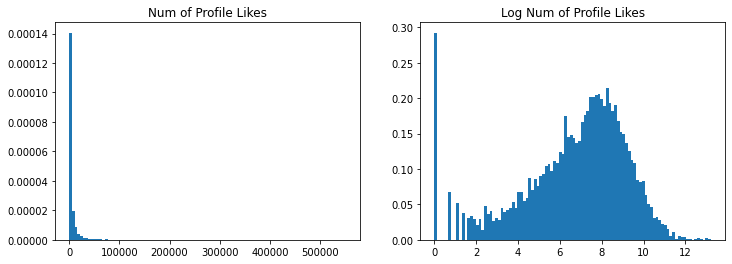

In [5]:
# target

def plot_log(feature):

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].hist(df[feature], density=True, bins=100)
    ax[0].set_title(feature)

    ax[1].hist(np.log1p(df[feature]), density=True, bins=100)
    ax[1].set_title(f'Log {feature}')
    plt.show()
    
plot_log('Num of Profile Likes')

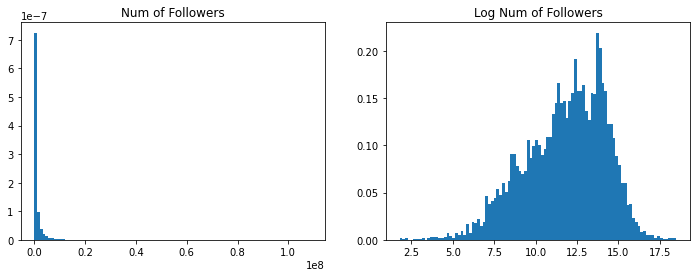

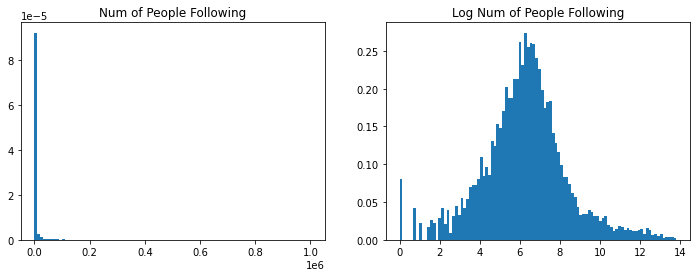

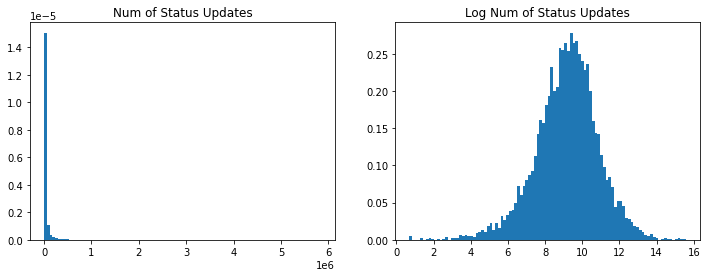

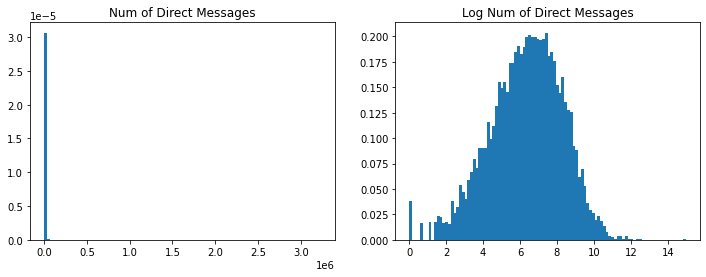

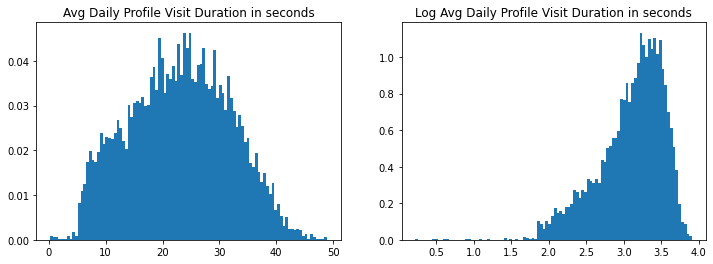

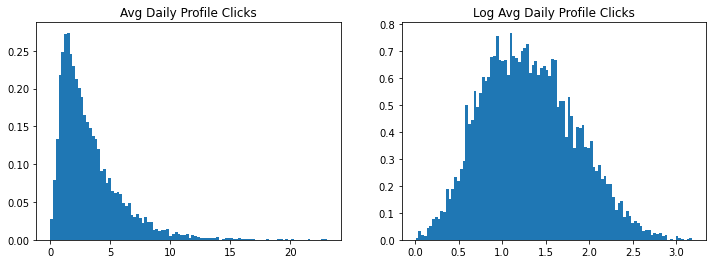

In [6]:
for feature in ['Num of Followers', 'Num of People Following',
                'Num of Status Updates', 'Num of Direct Messages',
                'Avg Daily Profile Visit Duration in seconds',
                'Avg Daily Profile Clicks']:
    plot_log(feature)

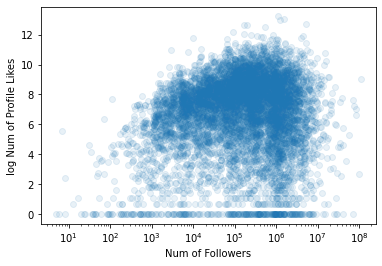

percentage of observations in plot: 100%


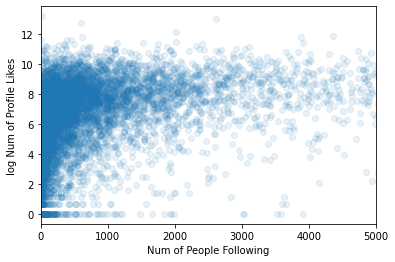

percentage of observations in plot: 89.3%


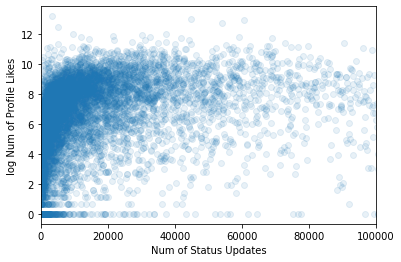

percentage of observations in plot: 93.0%


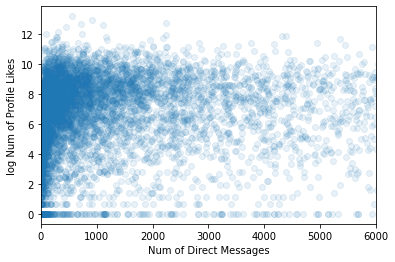

percentage of observations in plot: 89.8%


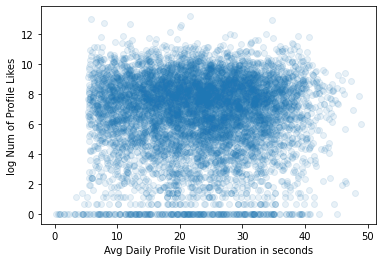

percentage of observations in plot: 100%


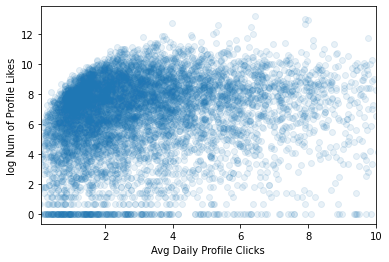

percentage of observations in plot: 97.4%


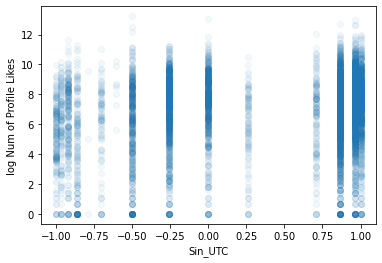

percentage of observations in plot: 100%


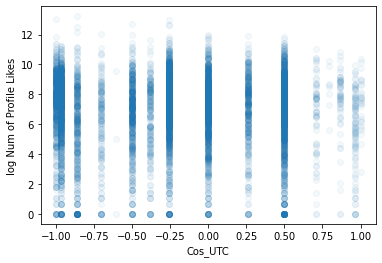

percentage of observations in plot: 100%


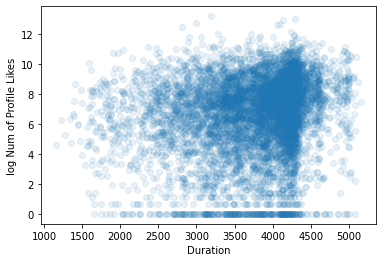

percentage of observations in plot: 100%


In [7]:
# numerical features

def plot(feature, alpha=0.1, xlim=None, xscale=None):
    plt.scatter(df[feature], df['log Num of Profile Likes'], alpha=alpha)
    plt.xlabel(feature)
    plt.ylabel('log Num of Profile Likes')
    if xlim is not None:
        plt.xlim(xlim)
    if xscale is not None:
        plt.xscale(xscale)
    plt.show()
    if xlim is not None:
        perc_obs = df[feature].between(xlim[0], xlim[1]).sum() / df[feature].notna().sum()
    else:
        perc_obs = 1
    print(f'percentage of observations in plot: {np.round(100*perc_obs, 1)}%')
    
    
plot('Num of Followers', xlim=None, xscale='log')
plot('Num of People Following', xlim=[0, 5e3])
plot('Num of Status Updates', xlim=[0, 1e5])
plot('Num of Direct Messages', xlim=[0, 6e3])
plot('Avg Daily Profile Visit Duration in seconds')
plot('Avg Daily Profile Clicks', xlim=[0.1, 10])
plot('Sin_UTC', alpha=0.05)
plot('Cos_UTC', alpha=0.05)
plot('Duration')


HAS PERSONAL URL:


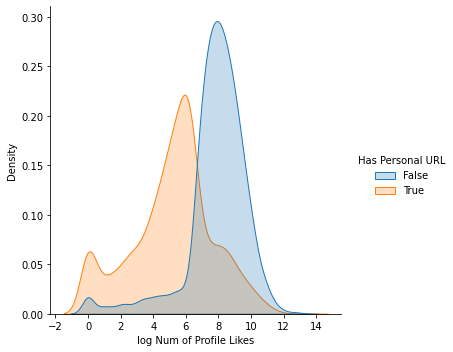

,count,mean,std,min,25%,50%,75%,max
Has Personal URL,,,,,,,,
False,4244.0,7.840617,1.910678,0.0,7.199678,8.051660,8.952540,13.025835
True,3256.0,5.156593,2.510062,0.0,3.784190,5.463832,6.463029,13.218755



PROFILE COVER IMAGE STATUS:


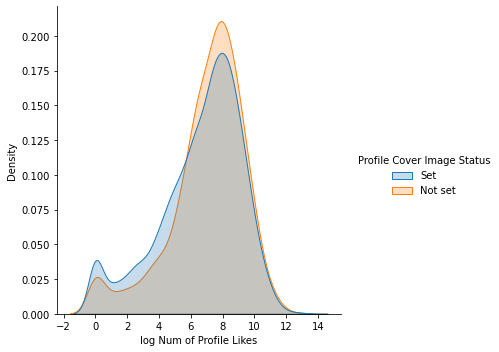

,count,mean,std,min,25%,50%,75%,max
Profile Cover Image Status,,,,,,,,
Not set,1691.0,6.982899,2.381051,0.0,5.973810,7.451242,8.604651,12.972119
Set,5719.0,6.588954,2.605455,0.0,5.153292,7.149917,8.450840,13.218755
NaN,90.0,6.390356,2.730335,0.0,5.212116,6.939851,8.372341,11.420064



PROFILE VERIFICATION STATUS:


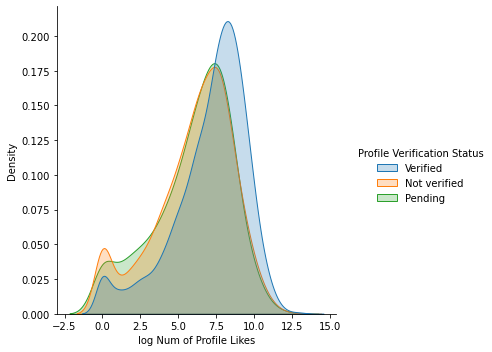

,count,mean,std,min,25%,50%,75%,max
Profile Verification Status,,,,,,,,
Not verified,2146.0,5.999016,2.615851,0.0,4.524491,6.473886,7.857287,12.736798
Pending,583.0,5.950570,2.583416,0.0,4.510618,6.541030,7.818227,12.063575
Verified,4771.0,7.068198,2.452259,0.0,5.874931,7.596894,8.755028,13.218755



IS PROFILE VIEW SIZE CUSTOMIZED?:


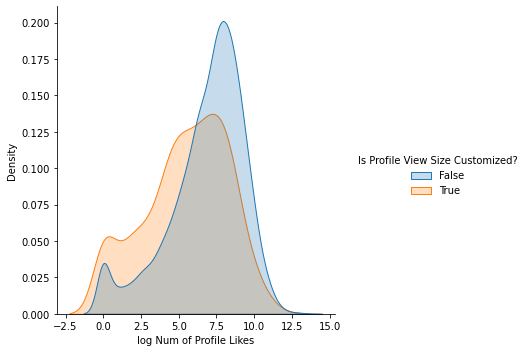

,count,mean,std,min,25%,50%,75%,max
Is Profile View Size Customized?,,,,,,,,
False,6785.0,6.803226,2.505665,0.0,5.545177,7.330405,8.550241,13.218755
True,715.0,5.462314,2.779316,0.0,3.663562,5.805135,7.633370,12.063575



LOCATION PUBLIC VISIBILITY:


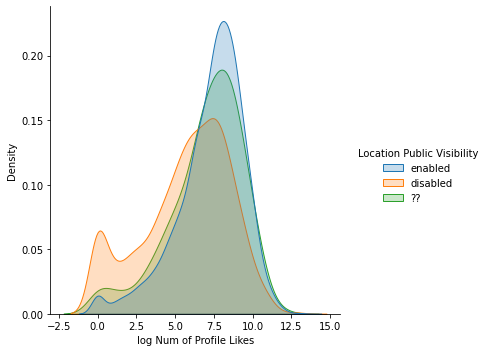

,count,mean,std,min,25%,50%,75%,max
Location Public Visibility,,,,,,,,
??,372.0,6.959449,2.389019,0.0,5.754950,7.395699,8.640163,12.063575
disabled,2773.0,5.679374,2.837389,0.0,3.970292,6.142037,7.805475,13.025835
enabled,4355.0,7.285333,2.166444,0.0,6.242221,7.678326,8.751395,13.218755



PROFILE CATEGORY:


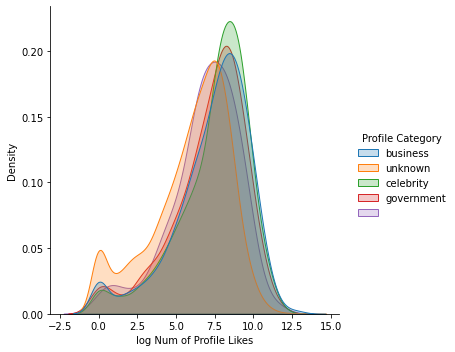

,count,mean,std,min,25%,50%,75%,max
Profile Category,,,,,,,,
,240.0,6.836923,2.261024,0.0,5.840526,7.188790,8.390199,11.616456
business,1839.0,7.304510,2.482292,0.0,6.108135,7.794823,9.028279,13.025835
celebrity,1401.0,7.399291,2.354773,0.0,6.276643,7.945910,8.992806,12.183960
government,660.0,7.098324,2.406681,0.0,5.906721,7.633612,8.727483,11.734299
unknown,3360.0,5.934610,2.542493,0.0,4.543295,6.467699,7.790386,13.218755


In [8]:
# small number of categories

def show_categories(feature):
    print(f'\n{feature.upper()}:')
    sns.displot(df, x='log Num of Profile Likes', hue=feature, 
            kind='kde', common_norm=False, fill=True)
    plt.show()
    display(df.groupby(df[feature], dropna=False)['log Num of Profile Likes'].describe())
    
for feature in ['Has Personal URL', 'Profile Cover Image Status',
                'Profile Verification Status', 
                'Is Profile View Size Customized?', 
                'Location Public Visibility', 'Profile Category']:
    show_categories(feature)


CAT PROFILE TEXT COLOR:


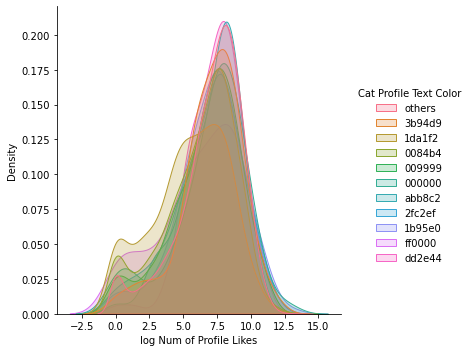

,count,mean,std,min,25%,50%,75%,max
Cat Profile Text Color,,,,,,,,
000000,162.0,6.946645,2.750212,0.0,5.794533,7.500916,8.764866,12.736798
0084b4,1284.0,6.212986,2.702512,0.0,4.675089,6.760372,8.142205,13.025835
009999,386.0,6.620968,2.580341,0.0,5.088855,7.098367,8.416652,11.462453
1b95e0,146.0,6.987016,2.447956,0.0,5.720846,7.273857,8.539571,12.972119
1da1f2,709.0,5.459272,2.787482,0.0,3.663562,5.802118,7.656810,12.063575
2fc2ef,134.0,6.728577,2.550774,0.0,5.173224,7.358455,8.408470,11.650624
3b94d9,171.0,7.053411,2.313985,0.0,5.951936,7.461640,8.625868,11.900790
abb8c2,151.0,7.029694,2.155536,0.0,5.652335,7.623153,8.545094,10.886689
dd2e44,102.0,7.342051,1.901335,0.0,6.056718,7.577811,8.674448,11.068012



CAT PROFILE PAGE COLOR:


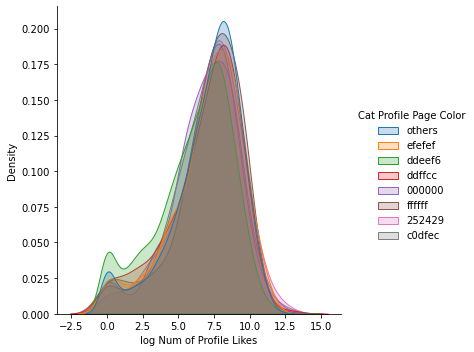

,count,mean,std,min,25%,50%,75%,max
Cat Profile Page Color,,,,,,,,
000000,490.0,6.805780,2.417763,0.0,5.498191,7.142404,8.540964,12.972119
252429,241.0,7.094267,2.396600,0.0,6.011267,7.474205,8.610501,12.736798
c0dfec,177.0,6.711493,2.453046,0.0,5.468060,7.117206,8.235361,12.529434
ddeef6,2456.0,6.112684,2.662955,0.0,4.584967,6.588236,8.053649,13.218755
ddffcc,306.0,6.783937,2.565470,0.0,5.542242,7.425540,8.600124,13.025835
efefef,713.0,6.942437,2.516734,0.0,5.786897,7.441907,8.712266,11.808367
ffffff,406.0,7.131269,2.377481,0.0,6.065415,7.596888,8.815837,12.657464
others,2711.0,6.971254,2.471570,0.0,5.797566,7.504942,8.687611,12.666903



CAT PROFILE THEME COLOR:


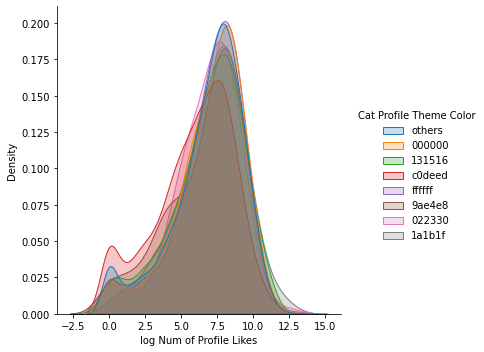

,count,mean,std,min,25%,50%,75%,max
Cat Profile Theme Color,,,,,,,,
000000,1038.0,6.980403,2.399106,0.0,5.785359,7.456449,8.655385,12.972119
022330,141.0,6.726782,2.371181,0.0,5.420535,7.204149,8.249052,12.529434
131516,602.0,6.791182,2.541151,0.0,5.522423,7.271607,8.606835,11.462453
1a1b1f,193.0,7.087733,2.372028,0.0,5.746203,7.487174,8.616676,12.736798
9ae4e8,177.0,6.577806,2.564562,0.0,4.905275,7.369601,8.488382,10.886689
c0deed,1486.0,5.909147,2.720114,0.0,4.276666,6.356102,7.884764,12.063575
ffffff,805.0,6.965306,2.418219,0.0,5.860786,7.435438,8.631949,13.218755
others,3058.0,6.822351,2.529598,0.0,5.614946,7.352762,8.563503,13.025835



CAT USER LANGUAGE:


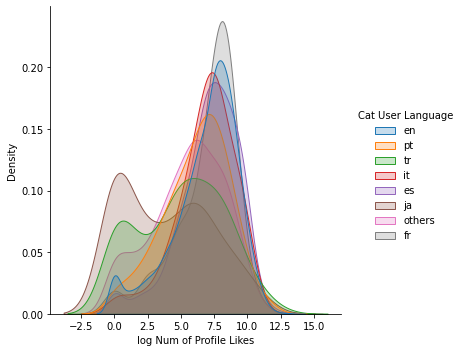

,count,mean,std,min,25%,50%,75%,max
Cat User Language,,,,,,,,
en,5321.0,6.824651,2.481149,0.0,5.564520,7.367077,8.550241,13.025835
es,869.0,7.107113,2.278092,0.0,5.955837,7.393263,8.726481,12.736798
fr,223.0,6.908974,2.303316,0.0,5.921219,7.575585,8.428690,11.046340
it,115.0,6.859812,2.200129,0.0,5.820879,7.163947,8.331611,10.835750
ja,129.0,3.896925,3.359262,0.0,0.000000,3.637586,6.411818,11.287128
others,431.0,5.528641,2.756036,0.0,3.772695,5.905362,7.619213,13.218755
pt,255.0,6.164244,2.503449,0.0,4.553821,6.526495,7.917724,12.000057
tr,157.0,5.021574,3.230759,0.0,2.397895,5.424950,7.510431,12.529434



CAT LOCATION:


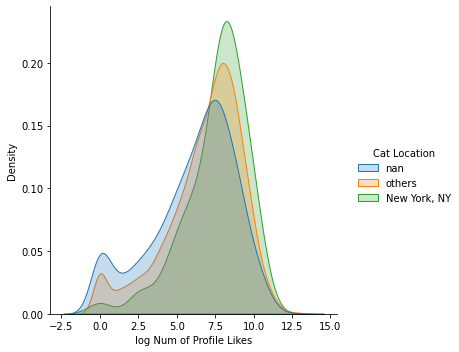

,count,mean,std,min,25%,50%,75%,max
Cat Location,,,,,,,,
"New York, NY",119.0,7.553197,2.046916,0.0,6.652674,8.017967,8.801699,10.775680
nan,1461.0,6.087777,2.753536,0.0,4.543295,6.661855,8.069029,12.657464
others,5920.0,6.802765,2.500701,0.0,5.516447,7.322841,8.555259,13.218755



CAT USER TIME ZONE:


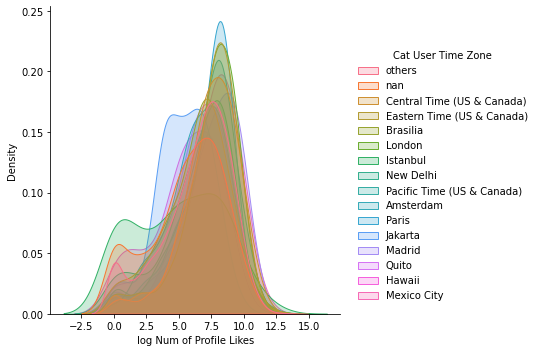

,count,mean,std,min,25%,50%,75%,max
Cat User Time Zone,,,,,,,,
Amsterdam,142.0,6.476330,2.263056,0.0,5.354150,6.676182,8.110683,11.144583
Brasilia,252.0,6.269708,2.507137,0.0,4.785400,6.642445,7.946962,12.000057
Central Time (US & Canada),510.0,7.416194,2.176951,0.0,6.282726,7.687539,8.898344,11.948726
Eastern Time (US & Canada),1205.0,7.367435,2.229981,0.0,6.295266,7.781973,8.837100,12.972119
Hawaii,103.0,5.470059,2.598681,0.0,4.118740,5.834811,7.472465,9.982576
Istanbul,122.0,4.985483,3.358397,0.0,2.079442,5.328677,7.879387,12.529434
Jakarta,145.0,5.363968,2.075492,0.0,3.891820,5.463832,6.877296,9.941554
London,490.0,7.392904,2.254387,0.0,6.401880,7.850491,8.887238,13.025835
Madrid,141.0,7.314305,2.477259,0.0,6.261492,7.911691,9.126415,11.044537


In [9]:
# lots of categories: need to aggregate

def agg_categories(feature, min_size=100):
    val_counts = df[feature].fillna('nan').value_counts()
    l_others = val_counts[val_counts < min_size].index.unique().tolist()
    df[f'Cat {feature}'] = df[feature].fillna('nan').replace(to_replace=l_others,
                                               value='others')
   
for feature in ['Profile Text Color', 'Profile Page Color',
                'Profile Theme Color', 'User Language', 'Location',
                'User Time Zone']:
    agg_categories(feature)
    show_categories(f'Cat {feature}')